In [ ]:
import sys
from pathlib import Path
# Change path if necessary, here the cajal repository (direcotry is placed outside the online-neuro) 
sys.path.append(str(Path('../..') / 'cajal'))   
sys.path.append(str(Path('..') / 'simulators'))

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from online_neuro.bayessian_optimizer import AskTellOptimizerHistory
from online_neuro.online_learning import build_model
from online_neuro.utils import CustomMinMaxScaler

from trieste.data import Dataset
from trieste.acquisition.function import PredictiveVariance, NegativePredictiveMean
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste import space

from cajal.nrn import Backend as N
from cajal.nrn.cells import MRG
from cajal.units import mm, um, mV, ms
from cajal.nrn.sources import IsotropicPoint
from cajal.units import ohm, cm
from cajal.nrn.monitors import StateMonitor, APMonitor
from cajal.nrn import SimulationEnvironment


In [73]:
# Set-up time resolution
N.dt = 0.05 * ms #The default one

In [74]:
def create_mrg(diameter: um=27, length: mm=100, v_init: mV=-80, verbose=False):
    # Create the axon model (MRG) with specified diameter, length, and initial voltage
    mrg = MRG(diameter=diameter, length=length, v_init=v_init)

    # If verbose mode is enabled, output detailed information about the axon
    if verbose:
        # Print the total number of nodes in the axon
        print(f"Computed number of Nodes: {len(mrg.node)}")

        # Calculate and print the total axon length based on the first and last node positions
        first_node_y = mrg.node[0].y3d(0)
        last_node_y = mrg.node[-1].y3d(0)
        total_length = (last_node_y - first_node_y) / 1000
        print(f"Computed Axon Length: {total_length:.2f} mm")

        # Print the 3D coordinates of the first and last nodes
        for node, node_name in zip([mrg.node[0], mrg.node[-1]], ['first', 'last']):
            x = node.x3d(0) / 1000  # Convert from um to mm
            y = node.y3d(0) / 1000
            z = node.z3d(0) / 1000
            print(f"Node position of the {node_name} node in the axon: x={x:.2f} mm, y={y:.2f} mm, z={z:.2f} mm")

    return mrg

def plot_setup(mrg, point_sources, labels=None):
    # Extract 3D coordinates of axon nodes and convert from um to mm
    node_x = np.array([n.x3d(0) for n in mrg.node]) / 1000.0
    node_y = np.array([n.y3d(0) for n in mrg.node]) / 1000.0
    node_z = np.array([n.z3d(0) for n in mrg.node]) / 1000.0

    # Set up the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the axon as a red line in 3D space
    ax.plot(node_x, node_y, node_z, color='red', label='Axon (MRG)', linewidth=2)

    # Plot each electrode as a green marker in 3D space
    for e, point_source in enumerate(point_sources):
        x = point_source.x.value / 1000.0  # Convert from um to mm
        y = point_source.y.value / 1000.0
        z = point_source.z.value / 1000.0

        # Use provided labels or default to "Electrode"
        label = labels[e] if labels else "Electrode"
        if label == 'Stim':
            ax.scatter(x, y, z, color='green', s=80, marker='o', label=label)
        else:
            ax.scatter(x, y, z, color='red', s=80, marker='^', label=label)

    # Add axis labels
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')

    # Adjust the viewing angle for better visualization
    ax.view_init(elev=20, azim=30)

    # Add a title and legend, and show the plot
    plt.title('Axon and the Stimulation and Blocking electrode position')
    plt.legend()
    plt.show()


In [ ]:
def plot_progression_AP_3D(mrg, v_rec):
    V = v_rec.v
    t = v_rec.t  # Time points recorded

    # Convert time to ms for plotting
    T = t / ms

    # Create meshgrids for node numbers and time steps
    nodes = np.arange(mrg.axonnodes)
    T_2D, N_2D = np.meshgrid(T, nodes, indexing='ij')  # shape: (time, nodes)
    V_t = V.T  # shape: (time, nodes)

    # Define membrane potential color limits
    vmin = -120
    vmax = 70

    # Create a 3D figure
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot surface
    surf = ax.plot_surface(N_2D, T_2D, V_t, cmap='jet', edgecolor='none', alpha=0.8,
                           vmin=vmin, vmax=vmax)

    # Set view to top-down
    ax.view_init(elev=90, azim=-90)

    # Hide z-axis (optional)
    ax.set_zlim(vmin, vmax)
    ax.set_zticks([])

    # Highlight the target point at node -26 and 5 ms
    target_node_idx = mrg.axonnodes + (-26)
    target_time = 5  # in ms

    # Interpolate z value (optional, here we use 0 for visibility)
    target_z = 0  # or np.mean(V)

    ax.scatter(
        target_node_idx, target_time, target_z,
        color='red', marker='x', s=80, linewidths=2, label='Target (Node -26, 5 ms)'
    )

    ax.set_xlabel('Node Number')
    ax.set_ylabel('Time (ms)')
    ax.set_title('AP Progression')

    fig.colorbar(surf, shrink=0.5, aspect=10, label='Membrane Potential (mV)')
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()


def plot_stim_and_block(stim, block, v_rec):  
    fig = plt.figure(figsize=(10, 6))
    
    t= v_rec.t 
    T = t / ms # time axes (X-as)

    plt.plot(T, -np.asarray(stim(t=v_rec.t)), label='stimulation')
    plt.plot(T, -np.asarray(block(t=v_rec.t)), label='block')
    plt.xlabel('Time (ms)')
    plt.ylabel('Waveform (mV)')
    plt.title(f'Electode waveforms during stimulation; \n Block: PW: {block.pw}, AMP: {block.amp}' 
              f' delay: {block.delay}, \n IG: {block.interphase_gap},  Decay Width: {block.decay_width}, Ramp width: {block.ramp_width}')
    plt.legend(loc="upper left")

    plt.show()

def plot_ramp_pulse(block, time):  
    fig = plt.figure(figsize=(10, 6))

    t = np.linspace(0, time, 1000) * ms # Last number is resolution of sample points
    signal = block.timecourse(t)

    plt.plot(t, -np.asarray(signal), label='stim')
    plt.xlabel('Time (ms)')
    plt.ylabel('Waveform (mV)')
    plt.title(f'Electode waveforms during stimulation; \n Block: PW: {block.pw}, AMP: {block.amp}' 
              f' delay: {block.delay}, \n IG: {block.interphase_gap},  Ramp1 Width: {block.decay_width}, Ramp2 width: {block.ramp_width}')
    plt.legend(loc="upper left")

    plt.show()



Computed number of Nodes: 119
Computed Axon Length: 69.17 mm
Node position of the first node in the axon: x=0.00 mm, y=-34.58 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=34.58 mm, z=0.00 mm
The position to hit 19.93 mm


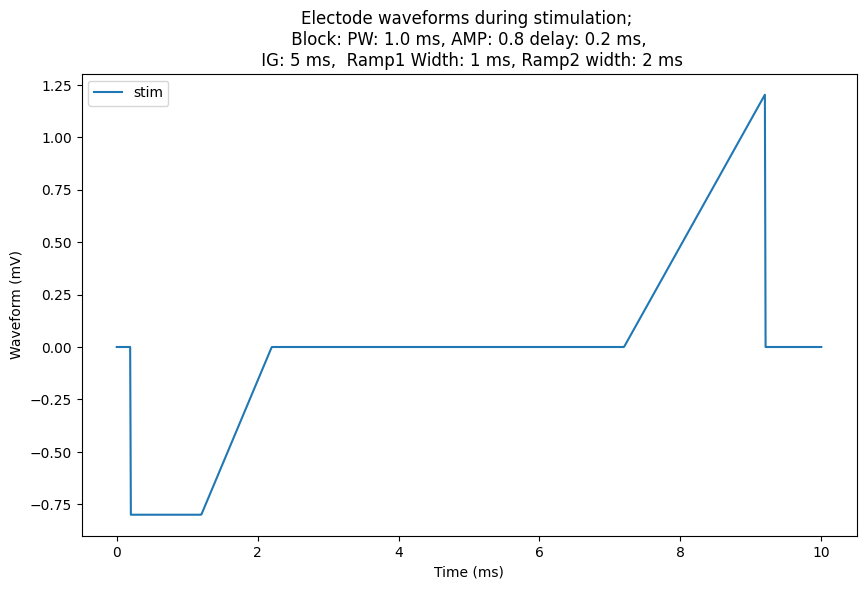

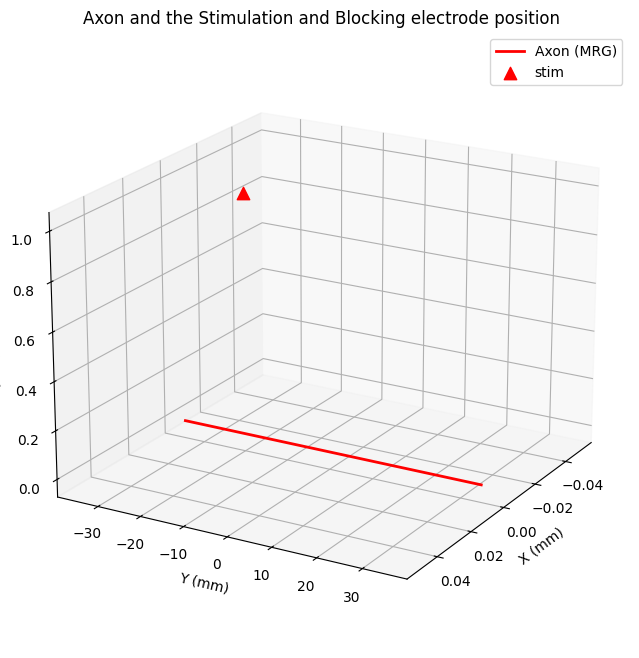

In [111]:
from simulators.python.pulses import PulseRamp

mrg = create_mrg(diameter=27, length=70, v_init=-80, verbose=True)

stim = PulseRamp(delay=0.2, amplitude=0.8, pulse_width=1.0,
                    interphase_gap=5, decay_width=1, k=1, ramp_width=2, # k =1  linear decay
                    tau=1, offset=0)

# Create electrodes at both sides of origin (spacing 20 mm) and 1 mm above the nerve
pointsource_stim = IsotropicPoint(x=0 * mm, y= -20 * mm, z=1 * mm, rhoe=500 * ohm * cm)

# Assign stimuli to electrodes
electrode_stim = pointsource_stim << stim

# Set up monitors not at the complete edges to avoid boundary conditions
ap_monitor_right = APMonitor(mrg.node[-26], threshold= -20 * mV) # Right side monitor (now 40 mm apart from stim)
v_rec = StateMonitor(mrg.node, "v")

y_position = mrg.node[-26].y3d(0) / 1000
print(f'The position to hit {y_position :.2f} mm')

plot_ramp_pulse(stim, time=10)
plot_setup(mrg, [pointsource_stim], ["stim"])

0.0 ms:   0%|          | 0/200 [00:00<?, ?it/s]

9.5 ms: 100%|██████████| 200/200 [00:01<00:00, 172.14it/s]


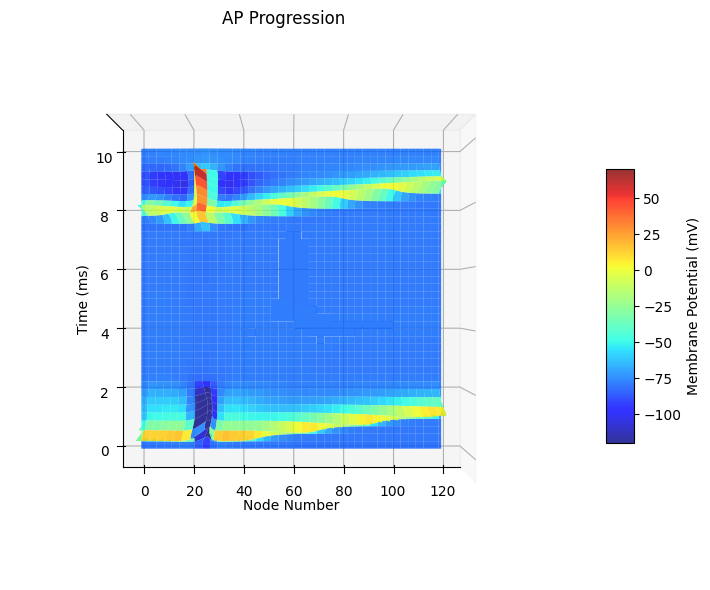

In [113]:
# Create the simulation environment
env = SimulationEnvironment(
    axons=[mrg],
    extra_stim=[electrode_stim],
    monitors=[
        v_rec,
        ap_monitor_right]
)

# Run the simulation for a sufficient duration to observe AP propagation
env.run(runtime = 10 * ms, progressbar=True, early_stopping=False)

plot_progression_AP_3D(mrg, v_rec)

In [145]:
def run_and_plot_stimulation(stim_amp, stim_pw, stim_ramp_width):
    mrg = create_mrg(diameter=27, length=70, v_init=-80, verbose=False)

    stim = PulseRamp(delay=0.2, amplitude=stim_amp, pulse_width=stim_pw,
                        interphase_gap=5, decay_width=stim_ramp_width, k=1, ramp_width=2, # k =1  linear decay
                        tau=1, offset=0)

    # Create electrodes at both sides of origin (spacing 20 mm) and 1 mm above the nerve
    pointsource_stim = IsotropicPoint(x=0 * mm, y= -20 * mm, z=1 * mm, rhoe=500 * ohm * cm)
    electrode_stim = pointsource_stim << stim

    ap_monitor_right = APMonitor(mrg.node[-26], threshold= -20 * mV) 
    v_rec = StateMonitor(mrg.node, "v")

    plot_ramp_pulse(stim, time=10)

    env = SimulationEnvironment(
        axons=[mrg],
        extra_stim=[electrode_stim],
        monitors=[
            v_rec,
            ap_monitor_right]
    )

    # Run the simulation for a sufficient duration to observe AP propagation
    env.run(runtime = 8 * ms, progressbar=True, early_stopping=False)

    plot_progression_AP_3D(mrg, v_rec)

In [ ]:
def AP_arrival_condition(ap_monitor_right, obj_arrival_time):

    ap_times = ap_monitor_right.spikes()
    print(f"All spike times at the right side: {ap_times}")

    if len(ap_times) == 0:
        missed_timing = obj_arrival_time # Increase penality when no AP generated??
    else:
        missed_timing = abs(ap_times[0] - obj_arrival_time)

    print(f'Time between 1 AP arrival at node and wanted time of {obj_arrival_time} ms: {missed_timing :.2f}')

    return missed_timing



def run_simulation(mrg, amp, pw, ramp_width):

    print(f"Configuration: Amplitude {amp:.2f} mA, Pulse Width {pw:.2f} ms, First ramp width {ramp_width:.2f}")

    stim = PulseRamp(delay=0.1, amplitude=amp, pulse_width=pw,
                    interphase_gap=5, decay_width=ramp_width, k=1, ramp_width=2, # k =1  linear decay
                    tau=1, offset=0)

    # Set spacing of 40 mm
    pointsource_stim = IsotropicPoint(x=0 * mm, y=-20 * mm, z=1 * mm, rhoe=500 * ohm * cm)

    # Assign stimuli to electrodes
    electrode_stim = pointsource_stim << stim

    # Set up monitors
    ap_monitor_right = APMonitor(mrg.node[-26], threshold= -20 * mV)
    v_rec = StateMonitor(mrg.node, "v")

    # Create the simulation environment
    env = SimulationEnvironment(
        axons=[mrg],
        extra_stim=[electrode_stim],
        monitors=[v_rec, ap_monitor_right]
    )

    # Run the simulation for a sufficient duration to observe AP propagation
    env.run(8 * ms, early_stopping=False)

    return AP_arrival_condition(ap_monitor_right, 5)


def AP_arrival_objective(mrg, params):
    """
    Objective function to optimize AP arrival time
    """
    
    amps, pws, ramp_widths = params[:, 0], params[:, 1], params[:, 2]
    
    observations = []
    
    for amp, pw, ramp_width in zip(amps, pws, ramp_widths):
        # Run the simulation with given parameters
        try:
            ap_count = run_simulation(mrg, amp, pw, ramp_width)
            observations.append(ap_count)

        except Exception as e:
            print(f"Simulation failed with amp={amp}, pulse width={pw}, ramp width={ramp_width}: {e}")
            observations.append(np.nan)  

    return np.array(observations).reshape(-1, 1)

In [147]:
# Define parameter bounds
lb = [-6.00, 0.05, 0.05]  # Lower bounds for [amp, pw, ramp_width]
ub = [6.00, 2.00, 3.0]  # Upper bounds

# Initialize scaler
scaler = CustomMinMaxScaler(feature_min=lb, feature_max=ub, output_range=(-1, 1))

# Define search space
search_space = space.Box(lower=[-1, -1, -1], upper=[1, 1, 1])

# Generate initial amount of samples 
init_samples = 15
qp_minmax = search_space.sample(init_samples).numpy()
qp = scaler.inverse_transform(qp_minmax)

# Set desired diameter, length and v_init
mrg = create_mrg(diameter=27, length=70, v_init=-80, verbose=True)

# Compute obvervations of for the initial amount of samples
observations = AP_arrival_objective(mrg, qp)

2025-05-06 13:49:57,660 rank[0] [INFO] The pulse ends after the simulation end time.


Computed number of Nodes: 119
Computed Axon Length: 69.17 mm
Node position of the first node in the axon: x=0.00 mm, y=-34.58 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=34.58 mm, z=0.00 mm
Configuration: Amplitude -1.79 mA, Pulse Width 0.84 ms, First ramp width 2.47


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 66.59it/s]
2025-05-06 13:49:59,587 rank[0] [INFO] The pulse ends after the simulation end time.


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00
Configuration: Amplitude 2.79 mA, Pulse Width 1.06 ms, First ramp width 0.51


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 34.74it/s]
2025-05-06 13:50:03,145 rank[0] [INFO] The pulse ends after the simulation end time.


All spike times at the right side: [0.8]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.20
Configuration: Amplitude 3.93 mA, Pulse Width 1.72 ms, First ramp width 2.99


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 53.27it/s]
2025-05-06 13:50:05,618 rank[0] [INFO] The pulse ends after the simulation end time.


All spike times at the right side: [0.75]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.25
Configuration: Amplitude 1.84 mA, Pulse Width 1.46 ms, First ramp width 2.45


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 36.07it/s]
2025-05-06 13:50:09,148 rank[0] [INFO] The pulse ends after the simulation end time.


All spike times at the right side: [0.85]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.15
Configuration: Amplitude -5.70 mA, Pulse Width 0.42 ms, First ramp width 2.30


5.5 ms: 100%|██████████| 120/120 [00:04<00:00, 28.31it/s]
2025-05-06 13:50:13,579 rank[0] [INFO] The pulse ends after the simulation end time.


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00
Configuration: Amplitude -0.96 mA, Pulse Width 0.80 ms, First ramp width 2.50


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 30.83it/s]
2025-05-06 13:50:17,790 rank[0] [INFO] The pulse ends after the simulation end time.


All spike times at the right side: [1.45]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.55
Configuration: Amplitude -5.96 mA, Pulse Width 1.76 ms, First ramp width 2.58


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 34.16it/s]
2025-05-06 13:50:21,420 rank[0] [INFO] The pulse ends after the simulation end time.


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00
Configuration: Amplitude -0.47 mA, Pulse Width 0.85 ms, First ramp width 0.76


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 67.33it/s]
2025-05-06 13:50:23,308 rank[0] [INFO] The pulse ends after the simulation end time.


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85
Configuration: Amplitude -0.05 mA, Pulse Width 1.27 ms, First ramp width 1.05


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 32.54it/s]
2025-05-06 13:50:27,163 rank[0] [INFO] The pulse ends after the simulation end time.


All spike times at the right side: [1.8]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.20
Configuration: Amplitude 0.86 mA, Pulse Width 0.32 ms, First ramp width 0.48


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 38.80it/s]
2025-05-06 13:50:30,433 rank[0] [INFO] The pulse ends after the simulation end time.


All spike times at the right side: [0.9]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.10
Configuration: Amplitude -2.56 mA, Pulse Width 0.91 ms, First ramp width 1.38


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 64.78it/s]
2025-05-06 13:50:32,446 rank[0] [INFO] The pulse ends after the simulation end time.


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00
Configuration: Amplitude -0.06 mA, Pulse Width 0.09 ms, First ramp width 1.57


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 30.81it/s]
2025-05-06 13:50:36,554 rank[0] [INFO] The pulse ends after the simulation end time.


All spike times at the right side: [1.7]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.30
Configuration: Amplitude -3.44 mA, Pulse Width 0.47 ms, First ramp width 2.84


5.5 ms: 100%|██████████| 120/120 [00:04<00:00, 29.59it/s]
2025-05-06 13:50:40,841 rank[0] [INFO] The pulse ends after the simulation end time.


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00
Configuration: Amplitude 3.19 mA, Pulse Width 1.27 ms, First ramp width 2.81


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 46.83it/s]
2025-05-06 13:50:43,575 rank[0] [INFO] The pulse ends after the simulation end time.


All spike times at the right side: [0.8]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.20
Configuration: Amplitude 1.79 mA, Pulse Width 0.48 ms, First ramp width 2.61


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 43.20it/s]

All spike times at the right side: [0.85]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.15


In [ ]:
# Create initial dataset (set query point in minmax)
init_dataset = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                       observations=tf.cast(observations, tf.float64))

# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp))

# Build model
model_config = {
    'classification': False,
    'variational': True,
    'sparse': False,
    'trainable_likelihood': True,
    'noise_free': True,
    'kernel_variance': 1e-7,
}
problem_type = 'regression'
online_model = build_model(init_dataset, search_space, model_config,
                           problem_type=problem_type)

# Set up acquisition function and rule
acq = PredictiveVariance() # Can swamp NegativePredictiveMean if normal min problem
rule = EfficientGlobalOptimization(builder=acq, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   overwrite=True,
                                   track_path='arrival_time')

In [161]:
# Optimization loop as for a next point to query
max_iters = 40  # Increase the number of iterations as needed
iter = 0

while iter < max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')

    qp_minmax_new = ask_tell.ask_and_save().numpy()
    qp_new = scaler.inverse_transform(qp_minmax_new)

    #print(f"Configuration: amplitude {qp_new[-1, 0]:.2f} mA, pulse with {qp_new[-1, 1]:.2f} with delay {qp_new[-1, 2]:.2f} ms")

    # Run the simulation and get observations
    observations_new = AP_arrival_objective(mrg, qp_new)

    if observations_new.ndim == 1:
        observations_new = observations_new.reshape(-1, 1)

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))

    # Create the new dataset
    tagged_output = Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(observations_new, tf.float64))
    
    # Update the optimizer with new data
    ask_tell.tell(tagged_output)
    iter += 1

# Save results
ask_tell.save()

2025-05-06 14:17:52,203 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 6.00 mA, Pulse Width 0.05 ms, First ramp width 0.05


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 30.48it/s]


All spike times at the right side: [0.8]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.20


2025-05-06 14:17:58,776 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -4.44 mA, Pulse Width 2.00 ms, First ramp width 0.05


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 34.66it/s]


All spike times at the right side: [3.1]
Time between 1 AP arrival at node and wanted time of 5 ms: 1.90


2025-05-06 14:18:04,441 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 6.00 mA, Pulse Width 2.00 ms, First ramp width 0.05


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 90.10it/s]


All spike times at the right side: [0.7]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.30


2025-05-06 14:18:07,975 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -6.00 mA, Pulse Width 0.05 ms, First ramp width 0.05


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 41.78it/s]


All spike times at the right side: [1.1]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.90


2025-05-06 14:18:12,374 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -6.00 mA, Pulse Width 2.00 ms, First ramp width 0.05


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 34.55it/s]


All spike times at the right side: [3.1]
Time between 1 AP arrival at node and wanted time of 5 ms: 1.90


2025-05-06 14:18:17,743 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 6.00 mA, Pulse Width 0.05 ms, First ramp width 3.00


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 30.07it/s]


All spike times at the right side: [0.7]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.30


2025-05-06 14:18:22,914 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 6.00 mA, Pulse Width 2.00 ms, First ramp width 1.57


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 47.10it/s]


All spike times at the right side: [0.7]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.30


2025-05-06 14:18:26,731 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 6.00 mA, Pulse Width 0.05 ms, First ramp width 1.53


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 35.19it/s]


All spike times at the right side: [0.7]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.30


2025-05-06 14:18:31,526 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -6.00 mA, Pulse Width 2.00 ms, First ramp width 1.44


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 36.86it/s]


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00


2025-05-06 14:18:36,795 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -6.00 mA, Pulse Width 0.05 ms, First ramp width 1.13


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 31.98it/s]


All spike times at the right side: [2.]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.00


2025-05-06 14:18:42,416 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -6.00 mA, Pulse Width 2.00 ms, First ramp width 3.00


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 37.48it/s]


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00


2025-05-06 14:18:47,175 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -6.00 mA, Pulse Width 0.05 ms, First ramp width 3.00


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 108.79it/s]


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00


2025-05-06 14:18:49,514 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 6.00 mA, Pulse Width 2.00 ms, First ramp width 0.88


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 47.92it/s]


All spike times at the right side: [0.7]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.30


2025-05-06 14:18:55,269 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 6.00 mA, Pulse Width 2.00 ms, First ramp width 3.00


5.5 ms: 100%|██████████| 120/120 [00:00<00:00, 179.38it/s]


All spike times at the right side: [0.7 3.7]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.30


2025-05-06 14:18:57,674 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.68 mA, Pulse Width 2.00 ms, First ramp width 0.05


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 93.10it/s] 


All spike times at the right side: [0.95]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.05


2025-05-06 14:19:01,006 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -1.64 mA, Pulse Width 0.05 ms, First ramp width 0.05


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 72.24it/s] 


All spike times at the right side: [1.05]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.95


2025-05-06 14:19:04,857 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 6.00 mA, Pulse Width 0.05 ms, First ramp width 2.19


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 73.18it/s] 


All spike times at the right side: [0.7]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.30


2025-05-06 14:19:08,185 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -1.21 mA, Pulse Width 2.00 ms, First ramp width 3.00


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 50.18it/s]


All spike times at the right side: [1.7]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.30


2025-05-06 14:19:12,854 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 1.70 mA, Pulse Width 2.00 ms, First ramp width 1.63


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 67.07it/s] 


All spike times at the right side: [0.85]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.15


2025-05-06 14:19:16,063 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 6.00 mA, Pulse Width 0.05 ms, First ramp width 0.80


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 54.48it/s]


All spike times at the right side: [0.7]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.30


2025-05-06 14:19:20,098 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.32 mA, Pulse Width 0.05 ms, First ramp width 3.00


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 51.84it/s]


All spike times at the right side: [1.25]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.75


2025-05-06 14:19:24,549 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -2.69 mA, Pulse Width 2.00 ms, First ramp width 1.87


5.5 ms: 100%|██████████| 120/120 [00:00<00:00, 166.67it/s]


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00


2025-05-06 14:19:27,527 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 3.07 mA, Pulse Width 0.05 ms, First ramp width 1.53


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 55.35it/s]


All spike times at the right side: [0.8]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.20


2025-05-06 14:19:31,890 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -1.97 mA, Pulse Width 2.00 ms, First ramp width 0.05


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 54.86it/s]


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00


2025-05-06 14:19:37,528 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -3.80 mA, Pulse Width 0.05 ms, First ramp width 0.05


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 77.62it/s]


All spike times at the right side: [1.1]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.90


2025-05-06 14:19:41,728 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 4.09 mA, Pulse Width 0.05 ms, First ramp width 0.05


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 62.22it/s]


All spike times at the right side: [0.8]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.20


2025-05-06 14:19:46,371 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 4.03 mA, Pulse Width 2.00 ms, First ramp width 1.36


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 80.60it/s]


All spike times at the right side: [0.75]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.25


2025-05-06 14:19:50,498 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -4.01 mA, Pulse Width 2.00 ms, First ramp width 3.00


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 57.05it/s]


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00


2025-05-06 14:19:55,335 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 4.00 mA, Pulse Width 2.00 ms, First ramp width 0.05


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 65.10it/s]


All spike times at the right side: [0.75]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.25


2025-05-06 14:19:59,627 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -4.12 mA, Pulse Width 0.05 ms, First ramp width 1.50


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 70.01it/s]


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00


2025-05-06 14:20:03,673 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 4.06 mA, Pulse Width 0.05 ms, First ramp width 3.00


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 75.85it/s]


All spike times at the right side: [0.75]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.25


2025-05-06 14:20:07,731 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.71 mA, Pulse Width 2.00 ms, First ramp width 3.00


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 50.50it/s]


All spike times at the right side: [0.95 3.45]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.05


2025-05-06 14:20:12,531 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -4.18 mA, Pulse Width 2.00 ms, First ramp width 1.18


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 50.70it/s]


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00


2025-05-06 14:20:16,977 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.47 mA, Pulse Width 2.00 ms, First ramp width 1.87


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 70.61it/s] 


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:20:21,558 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 2.06 mA, Pulse Width 0.05 ms, First ramp width 0.05


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 57.92it/s]


All spike times at the right side: [0.9]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.10


2025-05-06 14:20:25,668 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 4.58 mA, Pulse Width 2.00 ms, First ramp width 2.22


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 73.91it/s]


All spike times at the right side: [0.75]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.25


2025-05-06 14:20:29,547 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -1.84 mA, Pulse Width 0.05 ms, First ramp width 3.00


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 86.02it/s]


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00


2025-05-06 14:20:33,538 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -1.76 mA, Pulse Width 2.00 ms, First ramp width 0.95


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 56.84it/s]


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00


2025-05-06 14:20:38,046 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 2.26 mA, Pulse Width 2.00 ms, First ramp width 0.05


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 51.45it/s]


All spike times at the right side: [0.8]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.20


2025-05-06 14:20:42,918 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 4.46 mA, Pulse Width 0.05 ms, First ramp width 1.13


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 85.94it/s] 


All spike times at the right side: [0.75]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.25


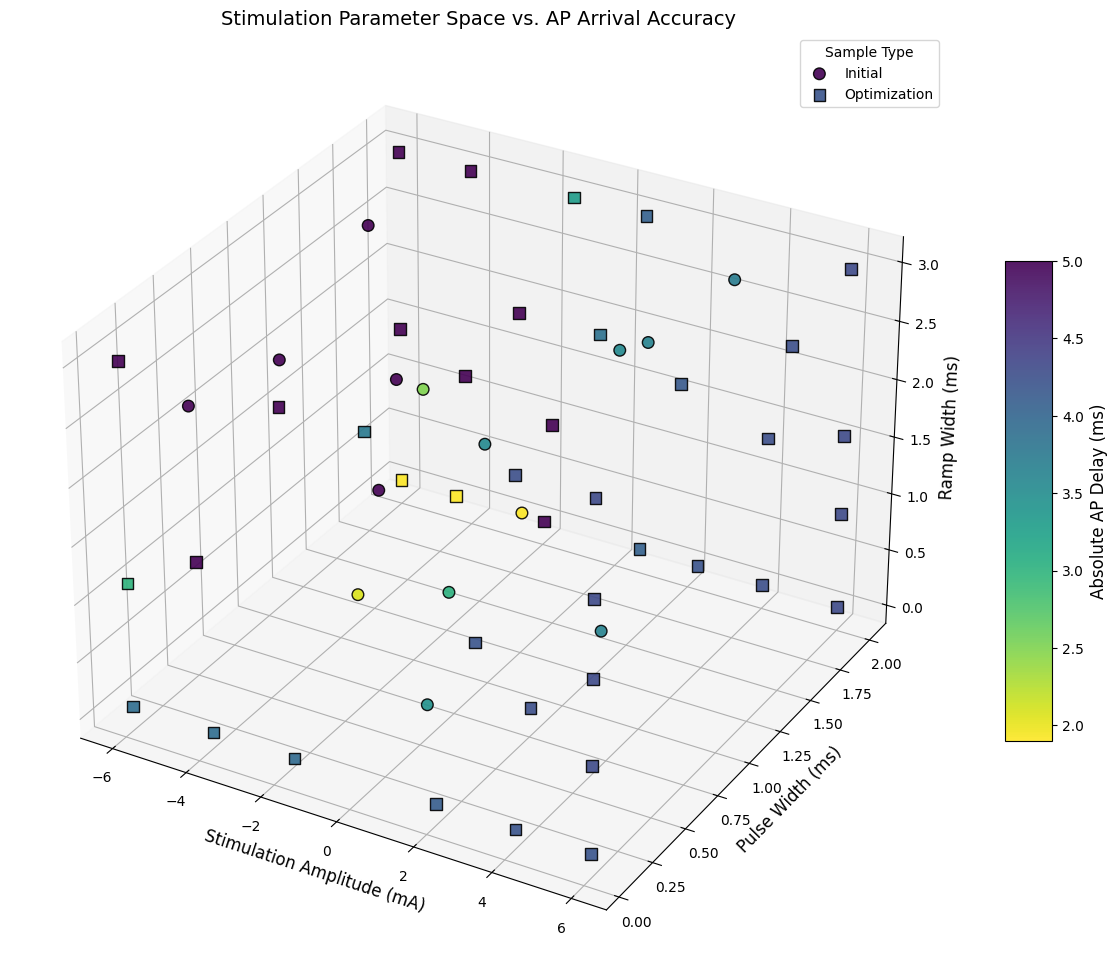

Top 10 configurations closest to target AP arrival:
    stim_amp   stim_pw  stim_ramp_width  ap_delay
16 -4.442979  2.000000         0.050000      1.90
19 -6.000000  2.000000         0.050000      1.90
24 -6.000000  0.050000         1.128415      3.00
8  -0.048553  1.274523         1.052169      3.20
11 -0.058022  0.093760         1.574630      3.30
32 -1.210138  2.000000         3.000000      3.30
5  -0.959119  0.803019         2.497801      3.55
35  0.317553  0.050000         3.000000      3.75
7  -0.473868  0.847460         0.756394      3.85
48 -0.469605  2.000000         1.873236      3.85


In [165]:
import pandas as pd

# Concatenate data
all_qp_array = np.vstack(all_qp)
all_observations_array = np.vstack(all_observations).flatten()
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
df = pd.DataFrame(all_qp_array, columns=['stim_amp', 'stim_pw', 'stim_ramp_width'])
df['ap_delay'] = all_observations_array
df['sample_type'] = all_sample_types_array

# Define markers
markers = {'Initial': 'o', 'Optimization': 's'}

# Create figure
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each sample type
for sample_type in df['sample_type'].unique():
    subset = df[df['sample_type'] == sample_type]
    if not subset.empty:
        sc = ax.scatter(
            subset['stim_amp'],
            subset['stim_pw'],
            subset['stim_ramp_width'],
            c=subset['ap_delay'],  # Color by how far the AP is from desired arrival time
            cmap='viridis_r',
            marker=markers[sample_type],
            label=sample_type,
            alpha=0.9,
            edgecolors='k',
            s=70
        )

# Add colorbar to indicate error from target
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Absolute AP Delay (ms)', fontsize=12)

# Axis labels and title
ax.set_xlabel('Stimulation Amplitude (mA)', fontsize=12)
ax.set_ylabel('Pulse Width (ms)', fontsize=12)
ax.set_zlabel('Ramp Width (ms)', fontsize=12)
ax.set_title('Stimulation Parameter Space vs. AP Arrival Accuracy', fontsize=14)

# Clean legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title='Sample Type', loc='best')

plt.tight_layout()
plt.savefig("AP_arrival_optimization_colored.png", dpi=300, bbox_inches='tight')
plt.show()

top_10 = df.sort_values(by='ap_delay').head(10)

print("Top 10 configurations closest to target AP arrival:")
print(top_10[['stim_amp', 'stim_pw', 'stim_ramp_width', 'ap_delay']])


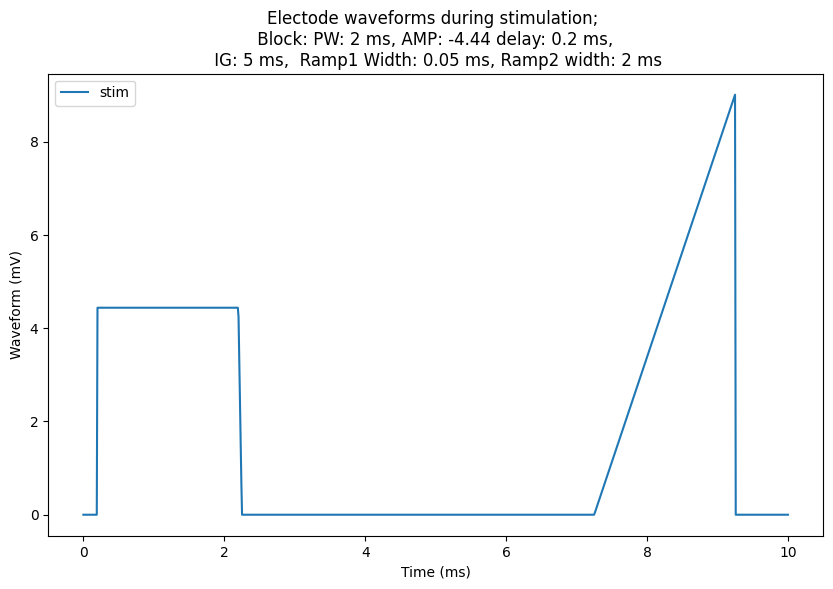

2025-05-06 14:21:56,094 rank[0] [INFO] The pulse ends after the simulation end time.
7.5 ms: 100%|██████████| 160/160 [00:04<00:00, 39.64it/s]


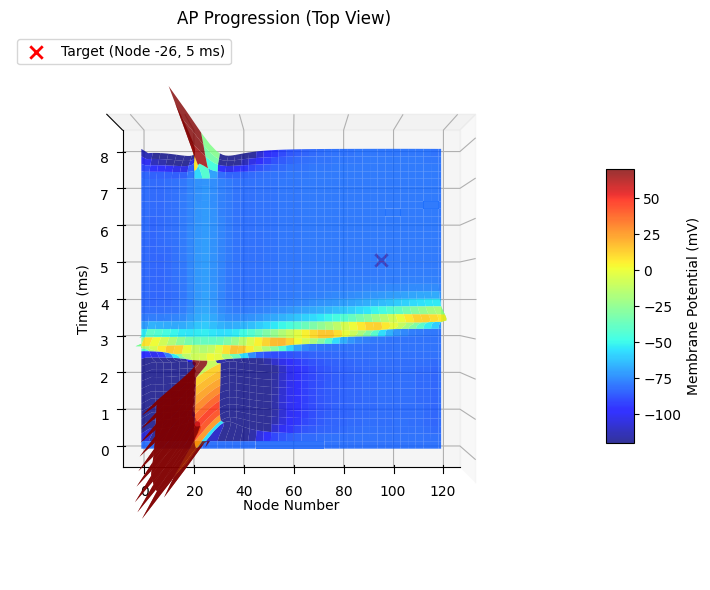

In [166]:
run_and_plot_stimulation(-4.44, 2, 0.05)

In [ ]:
# Create initial dataset (set query point in minmax)
init_dataset = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                       observations=tf.cast(observations, tf.float64))

# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp))

# Build model
model_config = {
    'classification': False,
    'variational': True,
    'sparse': False,
    'trainable_likelihood': True,
    'noise_free': True,
    'kernel_variance': 1e-7,
}
problem_type = 'regression'
online_model = build_model(init_dataset, search_space, model_config,
                           problem_type=problem_type)

# Set up acquisition function and rule
acq = NegativePredictiveMean() # Can swamp NegativePredictiveMean if normal min problem
rule = EfficientGlobalOptimization(builder=acq, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   overwrite=True,
                                   track_path='arrival_time_NPM')

# Optimization loop as for a next point to query
max_iters = 40  # Increase the number of iterations as needed
iter = 0

while iter < max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')

    qp_minmax_new = ask_tell.ask_and_save().numpy()
    qp_new = scaler.inverse_transform(qp_minmax_new)

    #print(f"Configuration: amplitude {qp_new[-1, 0]:.2f} mA, pulse with {qp_new[-1, 1]:.2f} with delay {qp_new[-1, 2]:.2f} ms")

    # Run the simulation and get observations
    observations_new = AP_arrival_objective(mrg, qp_new)

    if observations_new.ndim == 1:
        observations_new = observations_new.reshape(-1, 1)

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))

    # Create the new dataset
    tagged_output = Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(observations_new, tf.float64))
    
    # Update the optimizer with new data
    ask_tell.tell(tagged_output)
    iter += 1

# Save results
ask_tell.save()

2025-05-06 14:22:15,200 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.08 mA, Pulse Width 0.94 ms, First ramp width 2.30


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 43.61it/s]


All spike times at the right side: [1.3]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.70


2025-05-06 14:22:21,562 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.07 mA, Pulse Width 0.84 ms, First ramp width 1.85


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 44.48it/s]


All spike times at the right side: [1.35]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.65


2025-05-06 14:22:26,631 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.08 mA, Pulse Width 0.82 ms, First ramp width 1.81


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 42.99it/s]


All spike times at the right side: [1.3]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.70


2025-05-06 14:22:33,820 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.09 mA, Pulse Width 0.81 ms, First ramp width 1.75


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 76.14it/s]


All spike times at the right side: [1.25]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.75


2025-05-06 14:22:38,333 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.09 mA, Pulse Width 0.80 ms, First ramp width 1.70


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 76.54it/s] 


All spike times at the right side: [1.25]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.75


2025-05-06 14:22:43,172 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.10 mA, Pulse Width 0.80 ms, First ramp width 1.68


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 54.29it/s]


All spike times at the right side: [1.25]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.75


2025-05-06 14:22:47,176 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.10 mA, Pulse Width 0.79 ms, First ramp width 1.67


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 49.02it/s]


All spike times at the right side: [1.2]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.80


2025-05-06 14:22:51,913 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.10 mA, Pulse Width 0.79 ms, First ramp width 1.66


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 43.42it/s]


All spike times at the right side: [1.2]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.80


2025-05-06 14:22:59,438 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.11 mA, Pulse Width 0.79 ms, First ramp width 1.65


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 52.66it/s]


All spike times at the right side: [1.2]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.80


2025-05-06 14:23:04,491 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.11 mA, Pulse Width 0.79 ms, First ramp width 1.65


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 54.28it/s]


All spike times at the right side: [1.2]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.80


2025-05-06 14:23:09,703 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.12 mA, Pulse Width 0.79 ms, First ramp width 1.65


5.5 ms: 100%|██████████| 120/120 [00:00<00:00, 182.43it/s]


All spike times at the right side: [1.2]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.80


2025-05-06 14:23:12,836 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.12 mA, Pulse Width 0.78 ms, First ramp width 1.64


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 52.96it/s]


All spike times at the right side: [1.2]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.80


2025-05-06 14:23:17,771 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.12 mA, Pulse Width 0.78 ms, First ramp width 1.64


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 69.27it/s] 


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:23:22,547 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.12 mA, Pulse Width 0.79 ms, First ramp width 1.64


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 36.57it/s]


All spike times at the right side: [1.2]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.80


2025-05-06 14:23:29,438 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.13 mA, Pulse Width 0.78 ms, First ramp width 1.64


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 47.18it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:23:35,769 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.13 mA, Pulse Width 0.79 ms, First ramp width 1.64


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 46.99it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:23:41,852 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.13 mA, Pulse Width 0.79 ms, First ramp width 1.64


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 40.11it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:23:48,218 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.13 mA, Pulse Width 0.79 ms, First ramp width 1.64


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 41.67it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:23:53,811 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.13 mA, Pulse Width 0.79 ms, First ramp width 1.64


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 50.44it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:23:59,168 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.13 mA, Pulse Width 0.79 ms, First ramp width 1.64


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 79.00it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:24:04,621 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.14 mA, Pulse Width 0.79 ms, First ramp width 1.64


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 35.21it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:24:12,599 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.14 mA, Pulse Width 0.78 ms, First ramp width 1.64


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 39.06it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:24:20,400 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.14 mA, Pulse Width 0.78 ms, First ramp width 1.63


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 47.93it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:24:26,395 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.14 mA, Pulse Width 0.78 ms, First ramp width 1.63


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 35.87it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:24:33,020 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.15 mA, Pulse Width 0.78 ms, First ramp width 1.63


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 55.76it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:24:38,021 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.15 mA, Pulse Width 0.78 ms, First ramp width 1.62


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 59.92it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:24:43,388 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.15 mA, Pulse Width 0.78 ms, First ramp width 1.61


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 45.86it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:24:50,192 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.15 mA, Pulse Width 0.78 ms, First ramp width 1.59


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 47.90it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:24:56,304 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.14 mA, Pulse Width 0.78 ms, First ramp width 1.53


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 41.71it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:25:31,043 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.06 mA, Pulse Width 1.35 ms, First ramp width 0.28


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 56.24it/s]


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00


2025-05-06 14:25:45,599 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.34 mA, Pulse Width 0.05 ms, First ramp width 1.62


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 56.04it/s] 


All spike times at the right side: [1.25]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.75


2025-05-06 14:26:07,292 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.02 mA, Pulse Width 1.34 ms, First ramp width 1.28


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 45.27it/s]


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00


2025-05-06 14:26:12,577 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.12 mA, Pulse Width 0.07 ms, First ramp width 2.47


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 85.07it/s]


All spike times at the right side: [1.2]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.80


2025-05-06 14:26:16,427 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.08 mA, Pulse Width 0.19 ms, First ramp width 2.25


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 49.03it/s]


All spike times at the right side: [1.3]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.70


2025-05-06 14:26:21,643 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.08 mA, Pulse Width 0.20 ms, First ramp width 2.22


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 47.93it/s]


All spike times at the right side: [1.25]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.75


2025-05-06 14:26:27,167 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.08 mA, Pulse Width 0.22 ms, First ramp width 2.19


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 50.94it/s]


All spike times at the right side: [1.25]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.75


2025-05-06 14:26:32,515 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.09 mA, Pulse Width 0.23 ms, First ramp width 2.16


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 49.51it/s]


All spike times at the right side: [1.25]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.75


2025-05-06 14:26:38,152 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.09 mA, Pulse Width 0.24 ms, First ramp width 2.14


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 39.96it/s]


All spike times at the right side: [1.25]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.75


2025-05-06 14:26:44,654 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.10 mA, Pulse Width 0.25 ms, First ramp width 2.12


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 45.58it/s]


All spike times at the right side: [1.2]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.80


2025-05-06 14:26:50,085 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.10 mA, Pulse Width 0.27 ms, First ramp width 2.10


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 43.34it/s]


All spike times at the right side: [1.2]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.80


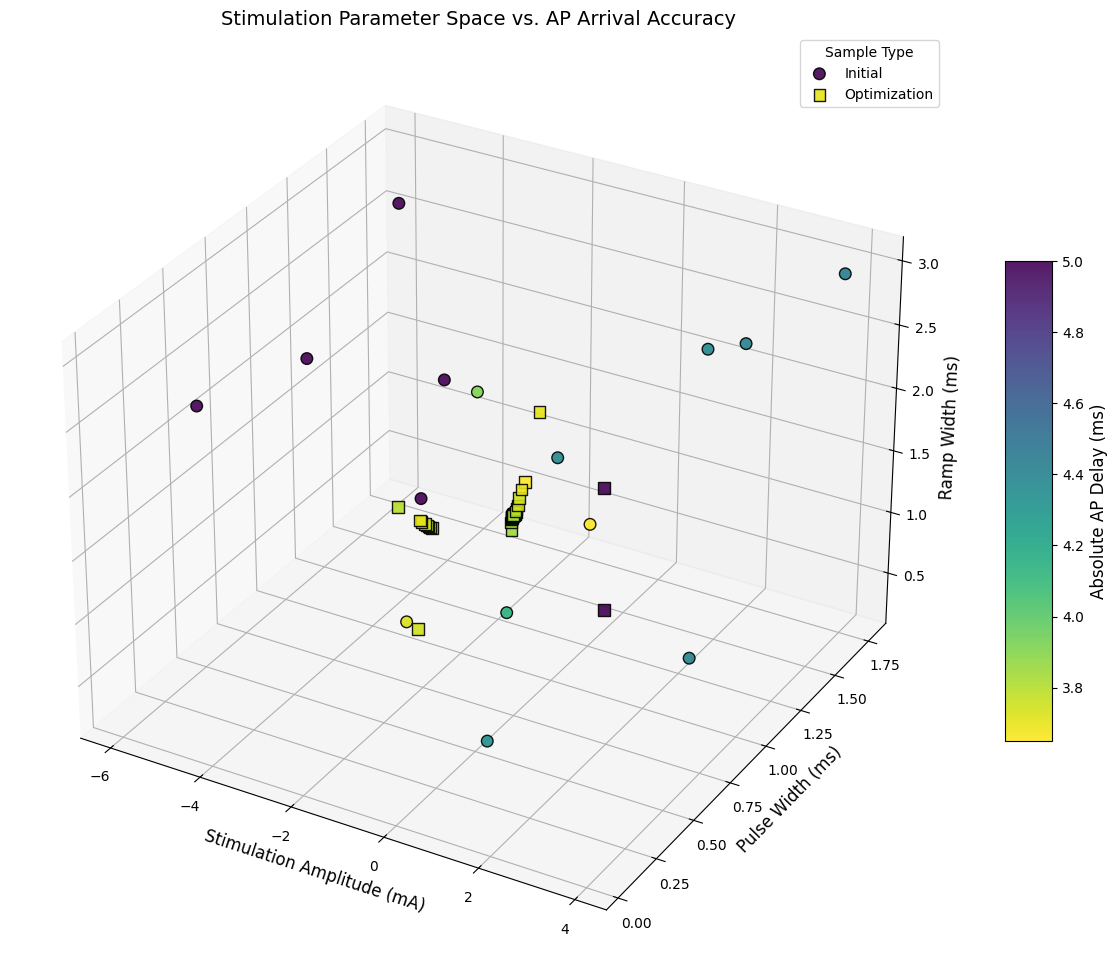

Top 10 configurations closest to target AP arrival:
    stim_amp   stim_pw  stim_ramp_width  ap_delay
8  -0.048553  1.274523         1.052169      3.20
11 -0.058022  0.093760         1.574630      3.30
5  -0.959119  0.803019         2.497801      3.55
16 -0.071967  0.841065         1.847500      3.65
48 -0.078435  0.186468         2.247778      3.70
17 -0.082310  0.824320         1.806546      3.70
15 -0.076649  0.936855         2.295029      3.70
52 -0.092695  0.242002         2.139714      3.75
51 -0.087462  0.230920         2.160300      3.75
50 -0.083724  0.216776         2.187475      3.75


In [168]:
import pandas as pd

# Concatenate data
all_qp_array = np.vstack(all_qp)
all_observations_array = np.vstack(all_observations).flatten()
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
df = pd.DataFrame(all_qp_array, columns=['stim_amp', 'stim_pw', 'stim_ramp_width'])
df['ap_delay'] = all_observations_array
df['sample_type'] = all_sample_types_array

# Define markers
markers = {'Initial': 'o', 'Optimization': 's'}

# Create figure
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each sample type
for sample_type in df['sample_type'].unique():
    subset = df[df['sample_type'] == sample_type]
    if not subset.empty:
        sc = ax.scatter(
            subset['stim_amp'],
            subset['stim_pw'],
            subset['stim_ramp_width'],
            c=subset['ap_delay'],  # Color by how far the AP is from desired arrival time
            cmap='viridis_r',
            marker=markers[sample_type],
            label=sample_type,
            alpha=0.9,
            edgecolors='k',
            s=70
        )

# Add colorbar to indicate error from target
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Absolute AP Delay (ms)', fontsize=12)

# Axis labels and title
ax.set_xlabel('Stimulation Amplitude (mA)', fontsize=12)
ax.set_ylabel('Pulse Width (ms)', fontsize=12)
ax.set_zlabel('Ramp Width (ms)', fontsize=12)
ax.set_title('Stimulation Parameter Space vs. AP Arrival Accuracy', fontsize=14)

# Clean legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title='Sample Type', loc='best')

plt.tight_layout()
plt.savefig("AP_arrival_optimization_colored.png", dpi=300, bbox_inches='tight')
plt.show()

top_10 = df.sort_values(by='ap_delay').head(10)

print("Top 10 configurations closest to target AP arrival:")
print(top_10[['stim_amp', 'stim_pw', 'stim_ramp_width', 'ap_delay']])

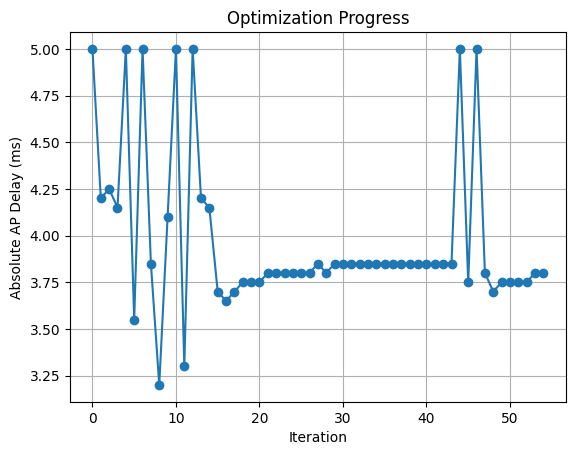

In [169]:
import matplotlib.pyplot as plt

all_ap_delays = np.concatenate(all_observations)
plt.plot(all_ap_delays, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Absolute AP Delay (ms)')
plt.title('Optimization Progress')
plt.grid(True)
plt.show()


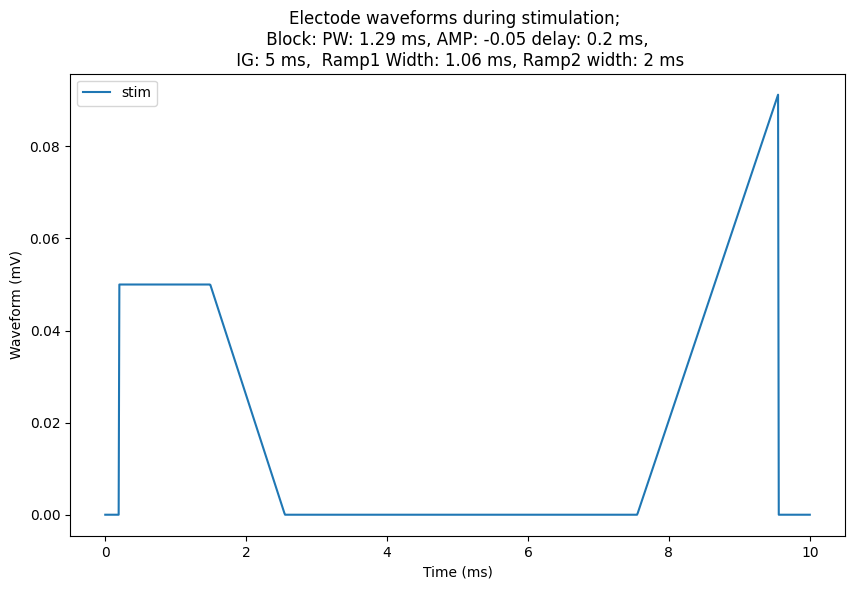

2025-05-06 15:53:07,024 rank[0] [INFO] The pulse ends after the simulation end time.
7.5 ms: 100%|██████████| 160/160 [00:05<00:00, 30.98it/s]


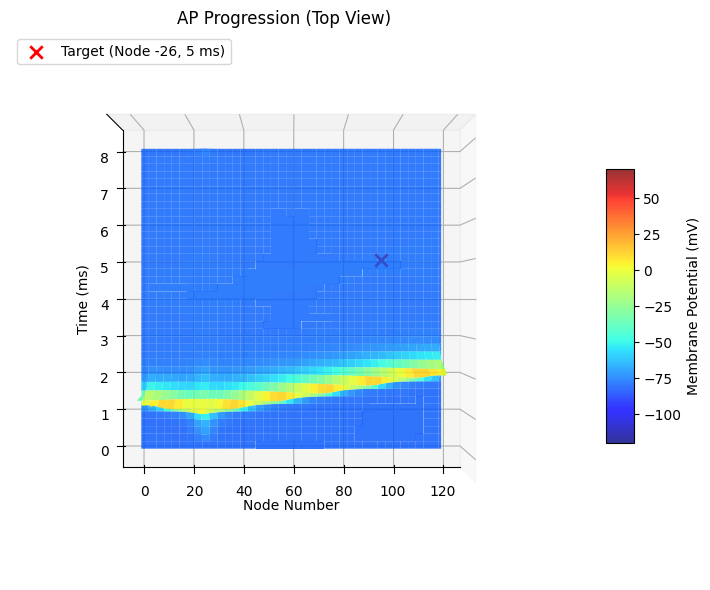

In [171]:
run_and_plot_stimulation(-0.05, 1.29, 1.06)

In [ ]:
from trieste.acquisition.function import ExpectedImprovement

# Create initial dataset (set query point in minmax)
init_dataset = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                       observations=tf.cast(observations, tf.float64))

# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp))

# Build model
model_config = {
    'classification': False,
    'variational': True,
    'sparse': False,
    'trainable_likelihood': True,
    'noise_free': True,
    'kernel_variance': 1e-7,
}
problem_type = 'regression'
online_model = build_model(init_dataset, search_space, model_config,
                           problem_type=problem_type)

# Set up acquisition function and rule
acq = ExpectedImprovement() # Can swamp NegativePredictiveMean if normal min problem
rule = EfficientGlobalOptimization(builder=acq, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   overwrite=True,
                                   track_path='arrival_time_NPM')

# Optimization loop as for a next point to query
max_iters = 40  # Increase the number of iterations as needed
iter = 0

while iter < max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')

    qp_minmax_new = ask_tell.ask_and_save().numpy()
    qp_new = scaler.inverse_transform(qp_minmax_new)

    #print(f"Configuration: amplitude {qp_new[-1, 0]:.2f} mA, pulse with {qp_new[-1, 1]:.2f} with delay {qp_new[-1, 2]:.2f} ms")

    # Run the simulation and get observations
    observations_new = AP_arrival_objective(mrg, qp_new)

    if observations_new.ndim == 1:
        observations_new = observations_new.reshape(-1, 1)

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))

    # Create the new dataset
    tagged_output = Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(observations_new, tf.float64))
    
    # Update the optimizer with new data
    ask_tell.tell(tagged_output)
    iter += 1

# Save results
ask_tell.save()

2025-05-06 14:06:50,914 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.04 mA, Pulse Width 1.16 ms, First ramp width 3.00


5.5 ms: 100%|██████████| 120/120 [00:04<00:00, 29.95it/s]


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00


2025-05-06 14:06:57,602 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 1.95 mA, Pulse Width 0.05 ms, First ramp width 0.53


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 38.51it/s]


All spike times at the right side: [0.85]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.15


2025-05-06 14:07:03,222 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 1.20 mA, Pulse Width 0.95 ms, First ramp width 0.50


5.5 ms: 100%|██████████| 120/120 [00:04<00:00, 26.95it/s]


All spike times at the right side: [0.9]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.10


2025-05-06 14:07:09,646 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.99 mA, Pulse Width 0.06 ms, First ramp width 0.91


5.5 ms: 100%|██████████| 120/120 [00:04<00:00, 26.61it/s]


All spike times at the right side: [0.9]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.10


2025-05-06 14:07:16,552 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.75 mA, Pulse Width 1.31 ms, First ramp width 0.70


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 58.99it/s]


All spike times at the right side: [0.95]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.05


2025-05-06 14:07:20,300 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.61 mA, Pulse Width 0.38 ms, First ramp width 1.03


5.5 ms: 100%|██████████| 120/120 [00:04<00:00, 24.90it/s]


All spike times at the right side: [1.]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.00


2025-05-06 14:07:27,780 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.48 mA, Pulse Width 0.88 ms, First ramp width 1.03


5.5 ms: 100%|██████████| 120/120 [00:04<00:00, 27.28it/s]


All spike times at the right side: [1.05]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.95


2025-05-06 14:07:36,039 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.37 mA, Pulse Width 0.05 ms, First ramp width 1.22


5.5 ms: 100%|██████████| 120/120 [00:05<00:00, 20.87it/s]


All spike times at the right side: [1.2]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.80


2025-05-06 14:07:45,698 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.21 mA, Pulse Width 0.32 ms, First ramp width 1.32


5.5 ms: 100%|██████████| 120/120 [00:04<00:00, 26.17it/s]


All spike times at the right side: [1.85]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.15


2025-05-06 14:07:53,672 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.02 mA, Pulse Width 0.48 ms, First ramp width 1.50


5.5 ms: 100%|██████████| 120/120 [00:05<00:00, 22.68it/s]


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00


2025-05-06 14:08:02,083 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 1.36 mA, Pulse Width 0.05 ms, First ramp width 0.71


5.5 ms: 100%|██████████| 120/120 [00:05<00:00, 21.28it/s]


All spike times at the right side: [0.85]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.15


2025-05-06 14:08:11,236 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 1.04 mA, Pulse Width 0.05 ms, First ramp width 0.77


5.5 ms: 100%|██████████| 120/120 [00:05<00:00, 21.03it/s]


All spike times at the right side: [0.9]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.10


2025-05-06 14:08:20,001 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.91 mA, Pulse Width 1.94 ms, First ramp width 0.30


5.5 ms: 100%|██████████| 120/120 [00:04<00:00, 24.57it/s]


All spike times at the right side: [0.9]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.10


2025-05-06 14:08:29,430 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.81 mA, Pulse Width 0.05 ms, First ramp width 0.90


5.5 ms: 100%|██████████| 120/120 [00:04<00:00, 26.71it/s]


All spike times at the right side: [0.95]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.05


2025-05-06 14:08:36,504 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.71 mA, Pulse Width 0.05 ms, First ramp width 0.92


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 33.03it/s]


All spike times at the right side: [0.95]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.05


2025-05-06 14:08:43,601 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.72 mA, Pulse Width 1.57 ms, First ramp width 0.76


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 45.45it/s]


All spike times at the right side: [0.95]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.05


2025-05-06 14:08:48,893 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.58 mA, Pulse Width 0.05 ms, First ramp width 0.98


5.5 ms: 100%|██████████| 120/120 [00:04<00:00, 25.78it/s]


All spike times at the right side: [1.]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.00


2025-05-06 14:08:55,964 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.51 mA, Pulse Width 0.05 ms, First ramp width 0.99


5.5 ms: 100%|██████████| 120/120 [00:05<00:00, 23.28it/s]


All spike times at the right side: [1.05]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.95


2025-05-06 14:09:03,646 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.53 mA, Pulse Width 1.32 ms, First ramp width 0.93


5.5 ms: 100%|██████████| 120/120 [00:04<00:00, 26.55it/s]


All spike times at the right side: [1.]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.00


2025-05-06 14:09:10,340 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.39 mA, Pulse Width 0.05 ms, First ramp width 1.03


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 40.05it/s]


All spike times at the right side: [1.2]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.80


2025-05-06 14:09:15,069 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.26 mA, Pulse Width 0.05 ms, First ramp width 1.01


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 30.14it/s]


All spike times at the right side: [1.9]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.10


2025-05-06 14:09:21,586 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude -0.07 mA, Pulse Width 0.05 ms, First ramp width 0.75


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 36.14it/s]


All spike times at the right side: []
Time between 1 AP arrival at node and wanted time of 5 ms: 5.00


2025-05-06 14:09:26,728 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 1.50 mA, Pulse Width 0.05 ms, First ramp width 1.45


5.5 ms: 100%|██████████| 120/120 [00:04<00:00, 28.08it/s]


All spike times at the right side: [0.85]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.15


2025-05-06 14:09:33,375 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 1.20 mA, Pulse Width 0.05 ms, First ramp width 1.38


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 68.56it/s] 


All spike times at the right side: [0.9]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.10


2025-05-06 14:09:36,802 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 1.01 mA, Pulse Width 1.40 ms, First ramp width 1.15


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 46.35it/s]


All spike times at the right side: [0.9]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.10


2025-05-06 14:09:41,510 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.93 mA, Pulse Width 0.05 ms, First ramp width 1.31


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 49.95it/s]


All spike times at the right side: [0.9]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.10


2025-05-06 14:09:46,270 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.81 mA, Pulse Width 1.40 ms, First ramp width 1.05


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 30.21it/s]


All spike times at the right side: [0.95]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.05


2025-05-06 14:09:52,449 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.76 mA, Pulse Width 0.05 ms, First ramp width 1.26


5.5 ms: 100%|██████████| 120/120 [00:01<00:00, 63.62it/s] 


All spike times at the right side: [0.95]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.05


2025-05-06 14:09:57,944 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.70 mA, Pulse Width 0.05 ms, First ramp width 1.24


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 32.34it/s]


All spike times at the right side: [0.95]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.05


2025-05-06 14:10:04,129 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.65 mA, Pulse Width 1.47 ms, First ramp width 1.00


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 38.62it/s]


All spike times at the right side: [0.95]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.05


2025-05-06 14:10:09,824 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.61 mA, Pulse Width 0.05 ms, First ramp width 1.22


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 47.81it/s]


All spike times at the right side: [1.]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.00


2025-05-06 14:10:14,766 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.57 mA, Pulse Width 0.05 ms, First ramp width 1.22


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 35.61it/s]


All spike times at the right side: [1.]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.00


2025-05-06 14:10:21,752 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.54 mA, Pulse Width 1.23 ms, First ramp width 1.08


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 47.81it/s]


All spike times at the right side: [1.]
Time between 1 AP arrival at node and wanted time of 5 ms: 4.00


2025-05-06 14:10:26,893 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.51 mA, Pulse Width 0.05 ms, First ramp width 1.24


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 30.61it/s]


All spike times at the right side: [1.05]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.95


2025-05-06 14:10:33,482 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.48 mA, Pulse Width 0.05 ms, First ramp width 1.25


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 46.64it/s]


All spike times at the right side: [1.05]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.95


2025-05-06 14:10:38,864 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.45 mA, Pulse Width 1.02 ms, First ramp width 1.16


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 39.26it/s]


All spike times at the right side: [1.05]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.95


2025-05-06 14:10:44,684 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.43 mA, Pulse Width 1.00 ms, First ramp width 1.18


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 50.87it/s]


All spike times at the right side: [1.1]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.90


2025-05-06 14:10:49,704 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.41 mA, Pulse Width 1.08 ms, First ramp width 1.20


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 36.69it/s]


All spike times at the right side: [1.1]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.90


2025-05-06 14:10:55,580 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.38 mA, Pulse Width 1.18 ms, First ramp width 1.21


5.5 ms: 100%|██████████| 120/120 [00:02<00:00, 42.63it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


2025-05-06 14:11:00,841 rank[0] [INFO] The pulse ends after the simulation end time.


Configuration: Amplitude 0.36 mA, Pulse Width 1.40 ms, First ramp width 1.22


5.5 ms: 100%|██████████| 120/120 [00:03<00:00, 31.54it/s]


All spike times at the right side: [1.15]
Time between 1 AP arrival at node and wanted time of 5 ms: 3.85


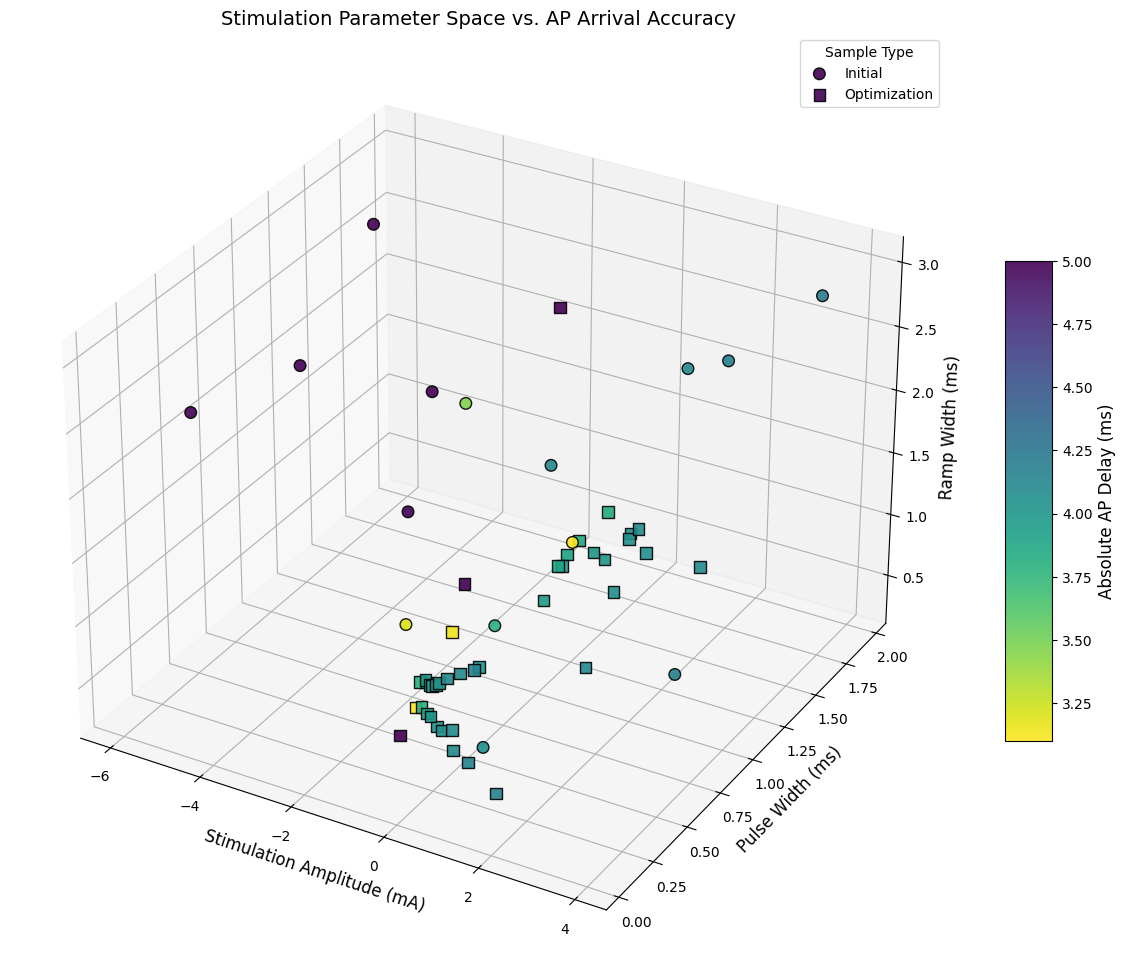

Top 10 configurations closest to target AP arrival:
    stim_amp   stim_pw  stim_ramp_width  ap_delay  abs_ap_delay
35  0.262161  0.050000         1.010615      3.10          3.10
23  0.207864  0.320976         1.318368      3.15          3.15
8  -0.048553  1.274523         1.052169      3.20          3.20
11 -0.058022  0.093760         1.574630      3.30          3.30
5  -0.959119  0.803019         2.497801      3.55          3.55
34  0.392835  0.050000         1.031048      3.80          3.80
22  0.365804  0.050000         1.223159      3.80          3.80
53  0.383468  1.175293         1.211941      3.85          3.85
54  0.359234  1.397902         1.223894      3.85          3.85
7  -0.473868  0.847460         0.756394      3.85          3.85


In [157]:
import pandas as pd

# Concatenate data
all_qp_array = np.vstack(all_qp)
all_observations_array = np.vstack(all_observations).flatten()
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
df = pd.DataFrame(all_qp_array, columns=['stim_amp', 'stim_pw', 'stim_ramp_width'])
df['ap_delay'] = all_observations_array
df['sample_type'] = all_sample_types_array
df['abs_ap_delay'] = np.abs(df['ap_delay'])

# Define markers
markers = {'Initial': 'o', 'Optimization': 's'}

# Create figure
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each sample type
for sample_type in df['sample_type'].unique():
    subset = df[df['sample_type'] == sample_type]
    if not subset.empty:
        sc = ax.scatter(
            subset['stim_amp'],
            subset['stim_pw'],
            subset['stim_ramp_width'],
            c=subset['abs_ap_delay'],  # Color by how far the AP is from desired arrival time
            cmap='viridis_r',
            marker=markers[sample_type],
            label=sample_type,
            alpha=0.9,
            edgecolors='k',
            s=70
        )

# Add colorbar to indicate error from target
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Absolute AP Delay (ms)', fontsize=12)

# Axis labels and title
ax.set_xlabel('Stimulation Amplitude (mA)', fontsize=12)
ax.set_ylabel('Pulse Width (ms)', fontsize=12)
ax.set_zlabel('Ramp Width (ms)', fontsize=12)
ax.set_title('Stimulation Parameter Space vs. AP Arrival Accuracy', fontsize=14)

# Clean legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title='Sample Type', loc='best')

plt.tight_layout()
plt.savefig("AP_arrival_optimization_colored.png", dpi=300, bbox_inches='tight')
plt.show()

top_10 = df.sort_values(by='abs_ap_delay').head(10)

print("Top 10 configurations closest to target AP arrival:")
print(top_10[['stim_amp', 'stim_pw', 'stim_ramp_width', 'ap_delay', 'abs_ap_delay']])

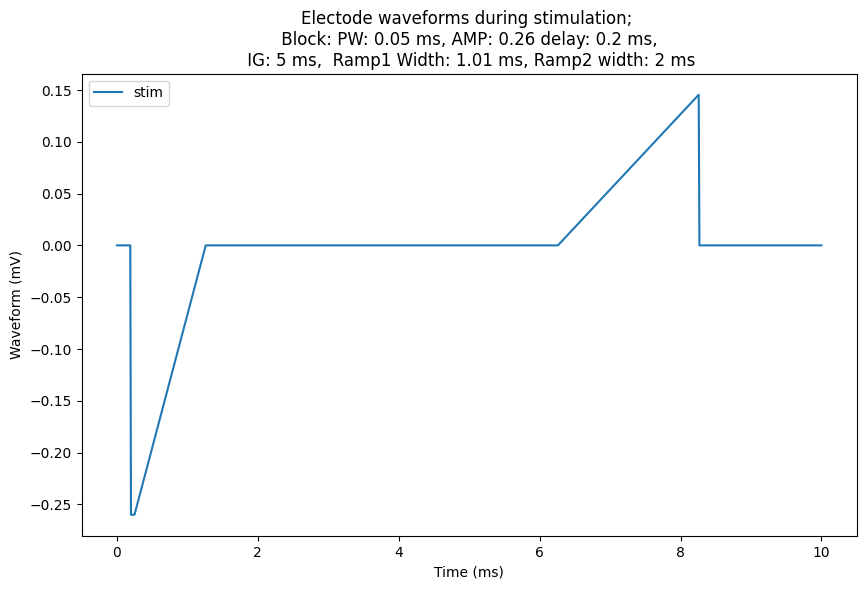

2025-05-06 14:16:22,764 rank[0] [INFO] The pulse ends after the simulation end time.
7.5 ms: 100%|██████████| 160/160 [00:03<00:00, 48.20it/s]


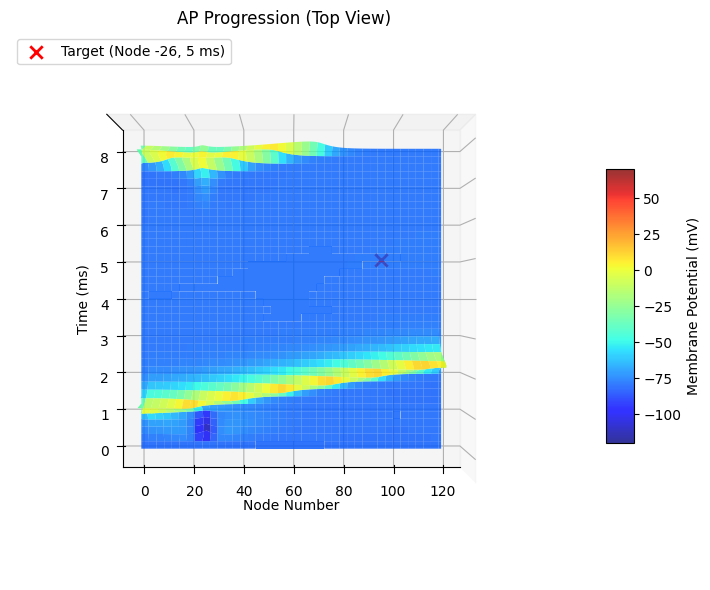

In [158]:
run_and_plot_stimulation(0.26, 0.05, 1.01)

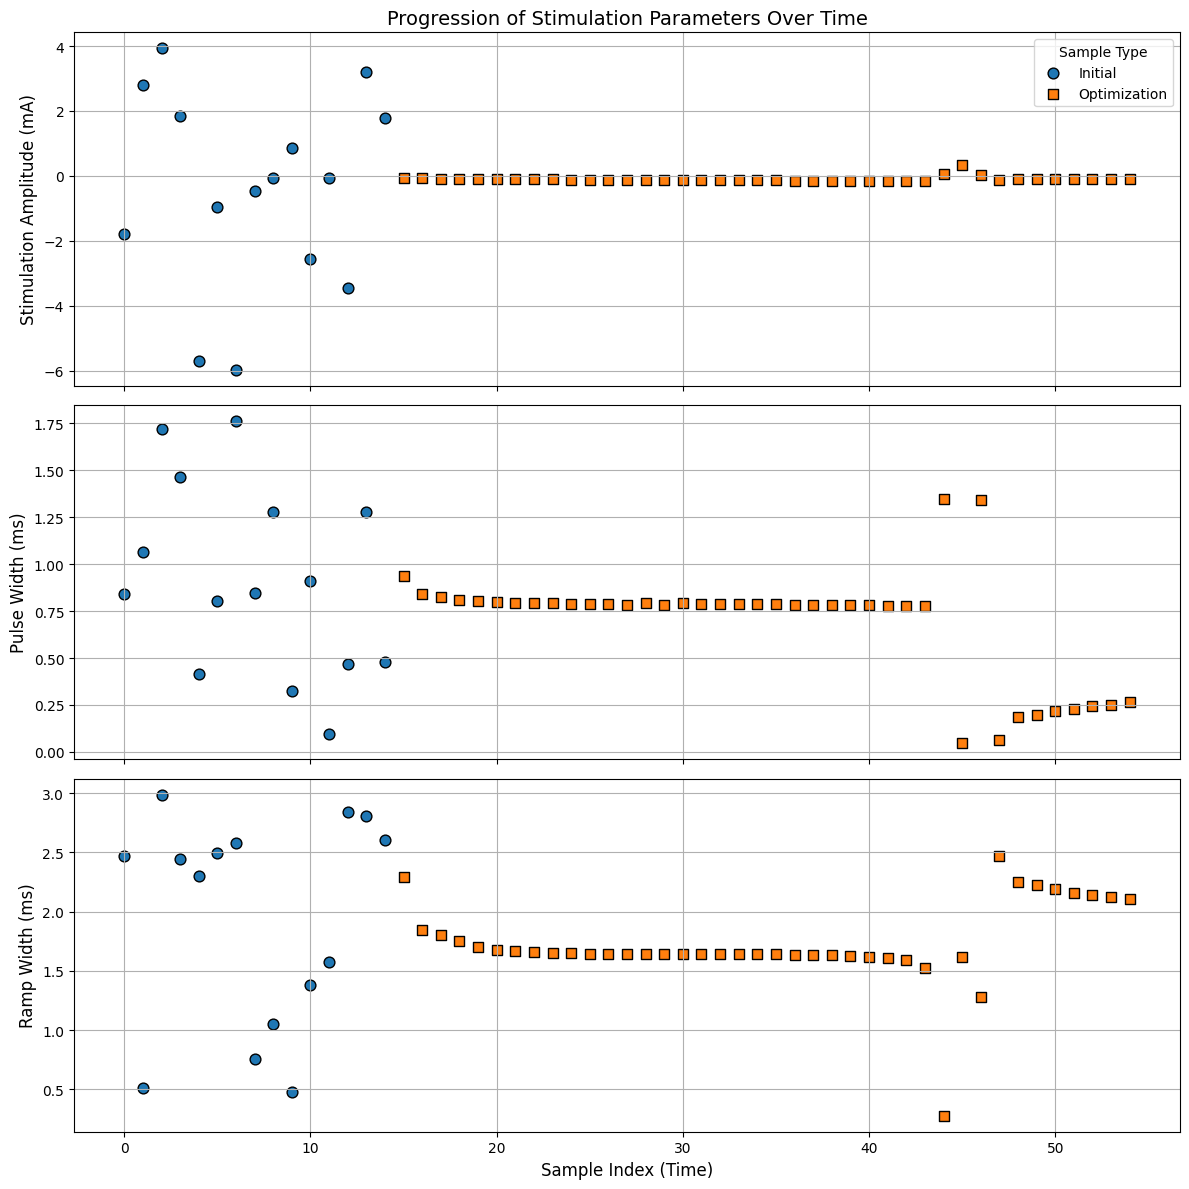

In [175]:
import matplotlib.pyplot as plt
import numpy as np

# Set up 3 vertically stacked plots
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Define consistent colors and markers
colors = {'Initial': 'tab:blue', 'Optimization': 'tab:orange'}
markers = {'Initial': 'o', 'Optimization': 's'}

# Plot 1: Stimulation Amplitude over time
for sample_type in df['sample_type'].unique():
    subset = df[df['sample_type'] == sample_type]
    axs[0].scatter(
        subset.index,
        subset['stim_amp'],
        label=sample_type,
        color=colors[sample_type],
        marker=markers[sample_type],
        s=60,
        edgecolors='k'
    )
axs[0].set_ylabel('Stimulation Amplitude (mA)', fontsize=12)
axs[0].set_title('Progression of Stimulation Parameters Over Time', fontsize=14)
axs[0].grid(True)

# Plot 2: Pulse Width over time
for sample_type in df['sample_type'].unique():
    subset = df[df['sample_type'] == sample_type]
    axs[1].scatter(
        subset.index,
        subset['stim_pw'],
        color=colors[sample_type],
        marker=markers[sample_type],
        s=60,
        edgecolors='k'
    )
axs[1].set_ylabel('Pulse Width (ms)', fontsize=12)
axs[1].grid(True)

# Plot 3: Ramp Width over time
for sample_type in df['sample_type'].unique():
    subset = df[df['sample_type'] == sample_type]
    axs[2].scatter(
        subset.index,
        subset['stim_ramp_width'],
        color=colors[sample_type],
        marker=markers[sample_type],
        s=60,
        edgecolors='k'
    )
axs[2].set_ylabel('Ramp Width (ms)', fontsize=12)
axs[2].set_xlabel('Sample Index (Time)', fontsize=12)
axs[2].grid(True)

# Add legend only once (to top plot)
axs[0].legend(title='Sample Type')

plt.tight_layout()
plt.savefig("stim_param_progression_overtime.png", dpi=300, bbox_inches='tight')
plt.show()
